<a href="https://colab.research.google.com/github/ian-summers/MLB-player-archetypes-by-age/blob/Data-ETL/Manual_ETL_Import.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import pyspark
except ImportError:
    !pip install pyspark

     ---------------------------------------- 0.0/317.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/317.0 MB ? eta -:--:--
     -------------------------------------- 0.0/317.0 MB 435.7 kB/s eta 0:12:08
     -------------------------------------- 0.1/317.0 MB 544.7 kB/s eta 0:09:42
     ---------------------------------------- 0.2/317.0 MB 1.5 MB/s eta 0:03:27
     ---------------------------------------- 0.6/317.0 MB 3.1 MB/s eta 0:01:42
     ---------------------------------------- 1.6/317.0 MB 6.3 MB/s eta 0:00:50
     ---------------------------------------- 2.8/317.0 MB 9.8 MB/s eta 0:00:32
     --------------------------------------- 3.9/317.0 MB 12.0 MB/s eta 0:00:27
      -------------------------------------- 5.2/317.0 MB 13.8 MB/s eta 0:00:23
      -------------------------------------- 6.5/317.0 MB 15.5 MB/s eta 0:00:21
     - ------------------------------------- 8.2/317.0 MB 17.4 MB/s eta 0:00:18
     - ------------------------------------- 9.0/317.0

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ImportCSV").getOrCreate()

In [ ]:
from google.colab import files


uploaded = files.upload()

In [27]:
import pandas as pd
import io

In [28]:
csv_files = [
    "batting_2023.csv",
    "batting_2022.csv",
    "batting_2021.csv",
    "batting_2020.csv",
    "batting_2019.csv",
    "batting_2018.csv",
    "batting_2017.csv",
    "batting_2016.csv",
    "batting_2015.csv",
    "batting_2014.csv",
    "batting_2013.csv",
]

# Read each CSV file and create a DataFrame
dataframes = []
for csv_file in csv_files:
    df = spark.read.csv(csv_file, header=True, inferSchema=True)
    dataframes.append(df)

# Union all DataFrames to create a single master DataFrame
master_df = dataframes[0]
for df in dataframes[1:]:
    master_df = master_df.union(df)

# Show the master DataFrame
master_df.show()

+-----+------+-----------------+---+---+---+---+--------------------+-------------------+----+-----+-----+-----+-----+-----+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+----+----+-------+-------------------+-----+-------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+------------------+--------------------+-------------------+------+----+---+
| IDfg|Season|             Name|Age|  G| AB| PA|                 BB%|                 K%|BB/K|  OBP|  SLG|  OPS|  ISO|BABIP|                LD%|                GB%|                FB%|              HR/FB|              Pull%|              Cent%|              Oppo%|              Soft%|               Med%|              Hard%|  EV|  LA|Barrels|            Barrel%|maxEV|HardHit|           HardHit%|             

In [29]:
from pyspark.sql import functions as F

age_count = master_df.select('Age').distinct().count()
print(age_count)

26


In [30]:
age_distribution = master_df.groupBy('Age').count().orderBy('Age')

age_distribution.show(age_distribution.count(), truncate=False)


+---+-----+
|Age|count|
+---+-----+
|19 |3    |
|20 |25   |
|21 |102  |
|22 |243  |
|23 |464  |
|24 |648  |
|25 |767  |
|26 |835  |
|27 |806  |
|28 |714  |
|29 |613  |
|30 |528  |
|31 |449  |
|32 |386  |
|33 |314  |
|34 |237  |
|35 |158  |
|36 |107  |
|37 |72   |
|38 |39   |
|39 |27   |
|40 |11   |
|41 |7    |
|42 |7    |
|43 |3    |
|44 |2    |
+---+-----+



In [35]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, lit


# Define the age brackets
age_brackets = [(1, 19, 23), (2, 24, 28), (3, 29, 34), (4, 35, 39), (5, 40, 44)]

# Initialize the complete_df DataFrame
complete_df = master_df

# Create a new column 'age_bracket'
age_column = None  # Initialize age_column variable
for bracket in age_brackets:
    bracket_num, start_age, end_age = bracket
# Create a when condition for the current age bracket
    age_condition = (complete_df['Age'] >= start_age) & (complete_df['Age'] <= end_age)
# Update the age_column with the current bracket number
    age_column = when(age_condition, bracket_num).otherwise(age_column)

# Add the 'age_bracket' column to the DataFrame
complete_df = complete_df.withColumn('age_bracket', age_column)

# Show the updated DataFrame
complete_df.show()

+-----+------+-----------------+---+---+---+---+--------------------+-------------------+----+-----+-----+-----+-----+-----+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+----+----+-------+-------------------+-----+-------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+------------------+--------------------+-------------------+------+----+---+-----------+
| IDfg|Season|             Name|Age|  G| AB| PA|                 BB%|                 K%|BB/K|  OBP|  SLG|  OPS|  ISO|BABIP|                LD%|                GB%|                FB%|              HR/FB|              Pull%|              Cent%|              Oppo%|              Soft%|               Med%|              Hard%|  EV|  LA|Barrels|            Barrel%|maxEV|HardHit|           HardHit%| 

In [37]:
# # Group by the 'age_bracket' column, compute the count and sort the results by age_bracket
age_bracket_counts_sorted = complete_df.groupBy('age_bracket').count().orderBy('age_bracket')

# Show the count of players in each age bracket sorted by age_bracket
age_bracket_counts_sorted.show()

+-----------+-----+
|age_bracket|count|
+-----------+-----+
|          1|  837|
|          2| 3770|
|          3| 2527|
|          4|  403|
|          5|   30|
+-----------+-----+



In [42]:
# Define the output path including the file name
output_path = "MLB-player-archetypes-by-age.csv"

# Save the DataFrame as CSV
complete_df.write.csv(output_path, header=True, mode="overwrite")

In [40]:
# Define the output path
output_path = "file:///C:/Users/18607/uu/homework/Project-4/baseballdatabank-2023.1.csv"

# Save the DataFrame as CSV
complete_df.write.csv(output_path, header=True, mode="overwrite")

In [5]:
import pandas as pd
from pathlib import Path
master_csv_path = Path("Resources/MLB-player-final-dataset.csv")
master_csv_read = pd.read_csv(master_csv_path)
master_summary_df = pd.DataFrame(master_csv_read)
master_summary_df.drop("Unnamed: 0", axis = 1, inplace = True)
master_summary_df['age_bracket'] = master_summary_df['age_bracket'].astype('category')
master_summary_df

,IDfg,Season,Name,Age,G,AB,PA,BB%,K%,BB/K,...,Z-Swing%,O-Contact%,Z-Contact%,F-Strike%,SwStr%,Zone%,Clutch,UBR,WAR,age_bracket
0,18401,2023,Ronald Acuna Jr.,25,159,643,735,0.109,0.114,0.95,...,0.728,0.738,0.878,0.589,0.078,0.422,1.16,2.2,8.4,2
1,13611,2023,Mookie Betts,30,152,584,693,0.139,0.154,0.90,...,0.630,0.643,0.939,0.595,0.058,0.421,-0.72,2.3,8.3,3
2,5361,2023,Freddie Freeman,33,161,637,730,0.099,0.166,0.60,...,0.792,0.688,0.880,0.614,0.094,0.426,-1.50,1.4,7.9,3
3,14344,2023,Matt Olson,29,162,608,720,0.144,0.232,0.62,...,0.735,0.695,0.777,0.556,0.119,0.395,-0.60,2.3,6.7,3
4,19755,2023,Shohei Ohtani,28,135,497,599,0.152,0.239,0.64,...,0.707,0.565,0.814,0.571,0.139,0.393,-2.08,1.7,6.6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7562,2437,2013,Maicer Izturis,32,107,365,399,0.068,0.095,0.71,...,0.609,0.804,0.937,0.569,0.048,0.447,-0.31,0.5,-1.6,3
7563,3856,2013,Jeff Keppinger,33,117,423,451,0.044,0.091,0.49,...,0.569,0.819,0.970,0.572,0.034,0.482,-0.32,-3.6,-1.7,3
7564,8585,2013,Yuniesky Betancourt,31,137,391,409,0.034,0.174,0.20,...,0.750,0.704,0.878,0.670,0.100,0.462,0.84,-0.6,-1.8,3
7565,2677,2013,Jordan Pacheco,27,95,247,262,0.038,0.145,0.26,...,0.631,0.788,0.913,0.626,0.060,0.492,-0.19,-0.2,-1.8,2


In [6]:
# Check data types of columns
print(master_summary_df.dtypes)

# Check for missing values in the "age" column
print(master_summary_df['Age'].isnull().sum())

# Print first few rows of DataFrame
print(master_summary_df.head())

IDfg              int64
Season            int64
Name             object
Age               int64
G                 int64
AB                int64
PA                int64
BB%             float64
K%              float64
BB/K            float64
OBP             float64
SLG             float64
OPS             float64
ISO             float64
BABIP           float64
LD%             float64
GB%             float64
FB%             float64
HR/FB           float64
Pull%           float64
Cent%           float64
Oppo%           float64
Soft%           float64
Med%            float64
Hard%           float64
EV              float64
LA              float64
Barrels           int64
Barrel%         float64
maxEV           float64
HardHit           int64
HardHit%        float64
CStr%           float64
CSW%            float64
O-Swing%        float64
Z-Swing%        float64
O-Contact%      float64
Z-Contact%      float64
F-Strike%       float64
SwStr%          float64
Zone%           float64
Clutch          

In [7]:
# Required imports
import pandas as pd
import hvplot.pandas
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [8]:
# Plot the clusters using the correct column names
master_summary_df.hvplot.scatter(
    x='BB/K',
    y='Age',
    by='age_bracket'
)

:NdOverlay   [age_bracket]
   :Scatter   [BB/K]   (Age)

In [9]:
# Plot the clusters using the correct column names
master_summary_df.hvplot.scatter(
    x='PA',
    y='Age',
    by='age_bracket'
)

:NdOverlay   [age_bracket]
   :Scatter   [PA]   (Age)

In [13]:
# Convert categorical variables into dummy/indicator variables (one-hot encoding)
master_summary_df = pd.get_dummies(master_summary_df, columns=['Name'])

In [18]:
# Import the PCA module
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

In [19]:
# Instantiate the imputer
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on your DataFrame
master_summary_df_imputed = pd.DataFrame(imputer.fit_transform(master_summary_df), columns=master_summary_df.columns)


In [21]:
pca=PCA(n_components=2)

In [22]:
# Fit the PCA model on the transformed Baseball DataFrame
master_pca = pca.fit_transform(master_summary_df_imputed)

# Review the first 5 rows of list data
master_pca[:5]

array([[ 7184.35133039,   714.46128059],
       [ 2394.6726416 ,   608.73925211],
       [-5855.54984731,   630.4277395 ],
       [ 3127.49652177,   651.51112447],
       [ 8539.19251021,   504.0922331 ]])

In [23]:
# Calculate the PCA explained variance ratio
pca.explained_variance_ratio_

array([0.99762283, 0.0023333 ])

In [24]:
# Create the PCA DataFrame
master_summary_df = pd.DataFrame(
    master_pca,
    columns=["PCA1", "PCA2"]
)

# Review the PCA DataFrame
master_summary_df.head()

,PCA1,PCA2
0,7184.351330,714.461281
1,2394.672642,608.739252
2,-5855.549847,630.427739
3,3127.496522,651.511124
4,8539.192510,504.092233


In [25]:
# Create a a list to store inertia values and the values of k
inertia = []
k = list(range(1, 11))

# Append the value of the computed inertia from the `inertia_` attribute of the KMeans model instance
for i in k:
    k_model = KMeans(n_clusters=i, random_state=1)
    k_model.fit(master_summary_df)
    inertia.append(k_model.inertia_)

# Define a DataFrame to hold the values for k and the corresponding inertia
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

# Review the DataFrame
df_elbow.head()

,k,inertia
0,1,2.792989e+11
1,2,8.973488e+10
2,3,4.158650e+10
3,4,2.643676e+10
4,5,1.802342e+10


In [26]:
# Plot the Elbow Curve
df_elbow.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve", 
    xticks=k
)

:Curve   [k]   (inertia)

In [27]:
# Define the model with 3 clusters
model = KMeans(n_clusters=3, random_state=0)

# Fit the model
model.fit(master_summary_df)

# Make predictions
k_3 = model.predict(master_summary_df)

# Create a copy of the PCA DataFrame
master_pca_predictions_df = master_summary_df.copy()

# Add a class column with the labels
master_pca_predictions_df["age_bracket"] = k_3

In [28]:
# Plot the clusters
master_pca_predictions_df.hvplot.scatter(
    x="PCA1",
    y="PCA2",
    by="age_bracket"
)

:NdOverlay   [age_bracket]
   :Scatter   [PCA1]   (PCA2)

In [29]:
# Define the model with 3 clusters
model = KMeans(n_clusters=4, random_state=0)

# Fit the model
model.fit(master_summary_df)

# Make predictions
k_4 = model.predict(master_summary_df)

# Create a copy of the PCA DataFrame
master_pca_predictions_df = master_summary_df.copy()

# Add a class column with the labels
master_pca_predictions_df["age_bracket"] = k_4

In [30]:
# Plot the clusters
master_pca_predictions_df.hvplot.scatter(
    x="PCA1",
    y="PCA2",
    by="age_bracket"
)

:NdOverlay   [age_bracket]
   :Scatter   [PCA1]   (PCA2)

In [ ]:
# This is additional analysis to gain a deeper understanding of the model's performance.
# A visualization of the predicted vs. actual values, examined residuals, and other 
# evaluation metrics such as R-squared, intercept and the coefficient

In [31]:
import pandas as pd
from pathlib import Path
master_csv_path = Path("Resources/MLB-player-final-dataset.csv")
master_csv_read = pd.read_csv(master_csv_path)
master_summary_df = pd.DataFrame(master_csv_read)
master_summary_df.drop("Unnamed: 0", axis = 1, inplace = True)
master_summary_df['age_bracket'] = master_summary_df['age_bracket'].astype('category')
master_summary_df

,IDfg,Season,Name,Age,G,AB,PA,BB%,K%,BB/K,...,Z-Swing%,O-Contact%,Z-Contact%,F-Strike%,SwStr%,Zone%,Clutch,UBR,WAR,age_bracket
0,18401,2023,Ronald Acuna Jr.,25,159,643,735,0.109,0.114,0.95,...,0.728,0.738,0.878,0.589,0.078,0.422,1.16,2.2,8.4,2
1,13611,2023,Mookie Betts,30,152,584,693,0.139,0.154,0.90,...,0.630,0.643,0.939,0.595,0.058,0.421,-0.72,2.3,8.3,3
2,5361,2023,Freddie Freeman,33,161,637,730,0.099,0.166,0.60,...,0.792,0.688,0.880,0.614,0.094,0.426,-1.50,1.4,7.9,3
3,14344,2023,Matt Olson,29,162,608,720,0.144,0.232,0.62,...,0.735,0.695,0.777,0.556,0.119,0.395,-0.60,2.3,6.7,3
4,19755,2023,Shohei Ohtani,28,135,497,599,0.152,0.239,0.64,...,0.707,0.565,0.814,0.571,0.139,0.393,-2.08,1.7,6.6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7562,2437,2013,Maicer Izturis,32,107,365,399,0.068,0.095,0.71,...,0.609,0.804,0.937,0.569,0.048,0.447,-0.31,0.5,-1.6,3
7563,3856,2013,Jeff Keppinger,33,117,423,451,0.044,0.091,0.49,...,0.569,0.819,0.970,0.572,0.034,0.482,-0.32,-3.6,-1.7,3
7564,8585,2013,Yuniesky Betancourt,31,137,391,409,0.034,0.174,0.20,...,0.750,0.704,0.878,0.670,0.100,0.462,0.84,-0.6,-1.8,3
7565,2677,2013,Jordan Pacheco,27,95,247,262,0.038,0.145,0.26,...,0.631,0.788,0.913,0.626,0.060,0.492,-0.19,-0.2,-1.8,2


In [32]:
print(master_summary_df.isna().sum())

IDfg              0
Season            0
Name              0
Age               0
G                 0
AB                0
PA                0
BB%               0
K%                0
BB/K              0
OBP               0
SLG               0
OPS               0
ISO               0
BABIP             0
LD%               0
GB%               0
FB%               0
HR/FB             0
Pull%             0
Cent%             0
Oppo%             0
Soft%             0
Med%              0
Hard%             0
EV             1443
LA             1443
Barrels           0
Barrel%        1441
maxEV          1443
HardHit           0
HardHit%       1441
CStr%             0
CSW%              0
O-Swing%          0
Z-Swing%          0
O-Contact%        1
Z-Contact%        0
F-Strike%         0
SwStr%            0
Zone%             0
Clutch            0
UBR             949
WAR               0
age_bracket       0
dtype: int64


In [33]:
master_summary_df.dropna(axis=1, inplace=True)  # Drop columns with missing values

In [34]:
print(master_summary_df.columns)

Index(['IDfg', 'Season', 'Name', 'Age', 'G', 'AB', 'PA', 'BB%', 'K%', 'BB/K',
       'OBP', 'SLG', 'OPS', 'ISO', 'BABIP', 'LD%', 'GB%', 'FB%', 'HR/FB',
       'Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%', 'Barrels',
       'HardHit', 'CStr%', 'CSW%', 'O-Swing%', 'Z-Swing%', 'Z-Contact%',
       'F-Strike%', 'SwStr%', 'Zone%', 'Clutch', 'WAR', 'age_bracket'],
      dtype='object')


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# Features (X) - Assuming all columns except 'IDfg', 'Season', 'Name', 'WAR' are features
X = master_summary_df.drop(['IDfg', 'Season', 'Name', 'WAR'], axis=1)

# Target variable (y) - 'WAR' column
y = master_summary_df['WAR']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.8833199099602066


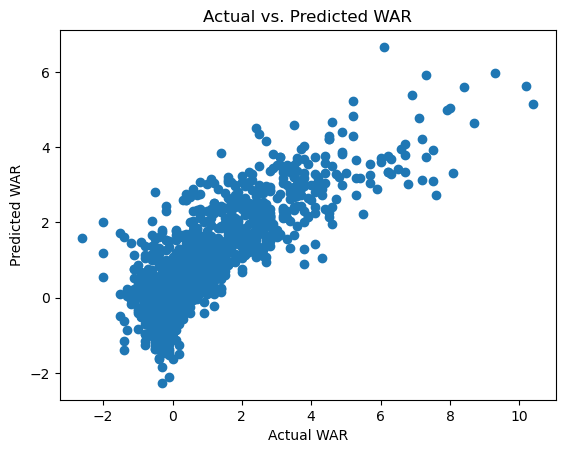

In [37]:
import matplotlib.pyplot as plt

plt.scatter(y_test, predictions)
plt.xlabel("Actual WAR")
plt.ylabel("Predicted WAR")
plt.title("Actual vs. Predicted WAR")
plt.show()

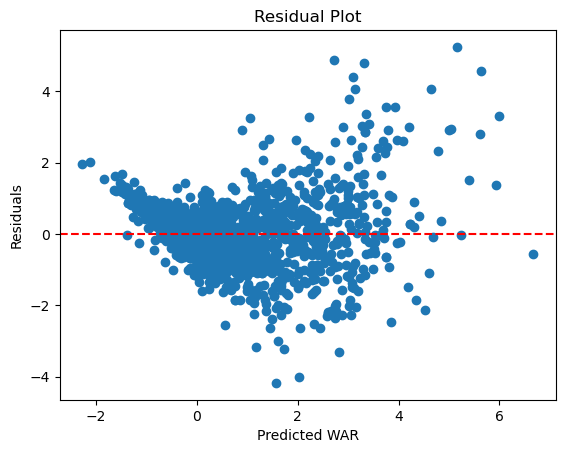

In [38]:
residuals = y_test - predictions
plt.scatter(predictions, residuals)
plt.xlabel("Predicted WAR")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

In [39]:
from sklearn.metrics import r2_score

r_squared = r2_score(y_test, predictions)
print("R-squared:", r_squared)

R-squared: 0.6664246406513832


In [40]:
coefficients = model.coef_
intercept = model.intercept_

print("Intercept:", intercept)
print("Coefficients:", coefficients)

Intercept: -12.48607806458564
Coefficients: [-2.86357660e-02 -1.89606588e-02 -3.09487518e-02  3.61370805e-02
 -6.50185748e+00  2.72899598e+00  8.59230383e-01 -1.48828162e+01
 -1.24933579e+01  1.80551508e+01 -1.47610874e+00 -2.41217461e+00
  5.72385287e-02  2.96142108e-01 -4.88155985e-01 -1.50393836e+00
 -3.60406844e+00 -3.39529083e+00 -3.09496704e+00  1.42438403e+01
  1.39324433e+01  1.30846563e+01  2.64039022e-02 -4.18999016e-03
  2.90273922e+01 -2.98871112e+01  6.05038764e-01 -5.95660849e-01
 -4.89949191e-01  6.98482471e-01  2.84524731e+01  2.50413602e+00
 -3.30765749e-02 -8.06322097e-03]
